In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForTokenClassification, AdamW
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

class BertModelTrainer:
    def __init__(self, tag2idx, max_len=75, batch_size=32, epochs=3):
        self.tag2idx = tag2idx
        self.max_len = max_len
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
        self.model = BertForTokenClassification.from_pretrained(
            "bert-base-cased",
            num_labels=len(tag2idx),
            output_attentions=False,
            output_hidden_states=False
        )
    
    def tokenize_and_preserve_labels(self, sentence, text_labels):
        tokenized_sentence = []
        labels = []

        for word, label in zip(sentence, text_labels):
            tokenized_word = self.tokenizer.tokenize(word)
            n_subwords = len(tokenized_word)

            tokenized_sentence.extend(tokenized_word)
            labels.extend([label] * n_subwords)

        return tokenized_sentence, labels
    
    def perform_iob_tagging(self, data):
        iob_tagged_data = []

        for sentence, tags in data:
            iob_tags = []
            prev_tag = 'O'
            
            for word, tag in zip(sentence, tags):
                iob_tag = 'O'

                if tag != 'O':
                    if prev_tag == tag:
                        iob_tag = 'I-' + tag
                    else:
                        iob_tag = 'B-' + tag
                    prev_tag = tag

                iob_tags.append(iob_tag)

            iob_tagged_data.append((sentence, iob_tags))

        return iob_tagged_data
    
    def train(self, data, labels):
        sentences = data['text'].to_list()
        labels = data['labels'].to_list()
        sentences = [sentence.split() for sentence in sentences]
        labels = [label.split() for label in labels]

        tag_values = ['O', 'CRED', 'DEB', 'AVBL', 'PAD']
        tag_values.append("PAD")

        tokenized_texts_and_labels = [
            self.tokenize_and_preserve_labels(sent, labs)
            for sent, labs in zip(sentences, labels)
        ]

        iob_tagged_data = self.perform_iob_tagging(tokenized_texts_and_labels)

        input_ids = pad_sequences([self.tokenizer.convert_tokens_to_ids(txt) for txt, _ in iob_tagged_data],
                                  maxlen=self.max_len, dtype="long", value=0.0,
                                  truncating="post", padding="post")
        tags = pad_sequences([[self.tag2idx.get(l) for l in lab] for _, lab in iob_tagged_data],
                             maxlen=self.max_len, value=self.tag2idx["PAD"], padding="post",
                             dtype="long", truncating="post")
        attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

        tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                                    random_state=2018, test_size=0.1)
        tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                                     random_state=2018, test_size=0.1)

        tr_inputs = torch.tensor(tr_inputs)
        val_inputs = torch.tensor(val_inputs)
        tr_tags = torch.tensor(tr_tags)
        val_tags = torch.tensor(val_tags)
        tr_masks = torch.tensor(tr_masks)
        val_masks = torch.tensor(val_masks)

        train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=self.batch_size)

        valid_data = TensorDataset(val_inputs, val_masks, val_tags)
        valid_sampler = SequentialSampler(valid_data)
        valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=self.batch_size)

        optimizer = AdamW(
            self.model.parameters(),
            lr=3e-5,
            eps=1e-8
        )

        total_steps = len(train_dataloader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        self.model.to(self.device)
        self.model.train()

        for _ in range(self.epochs):
            for step, batch in enumerate(train_dataloader):
                batch = tuple(t.to(self.device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                self.model.zero_grad()
                outputs = self.model(b_input_ids, token_type_ids=None,
                                     attention_mask=b_input_mask, labels=b_labels)
                loss = outputs[0]
                loss.backward()
                torch.nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

    def evaluate(self, data):
        self.model.eval()
        predictions, true_labels = [], []

        dataloader = DataLoader(data, batch_size=self.batch_size)
        for batch in dataloader:
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            with torch.no_grad():
                outputs = self.model(b_input_ids, token_type_ids=None,
                                     attention_mask=b_input_mask, labels=b_labels)
                logits = outputs[1].detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
                true_labels.extend(label_ids)

        return predictions, true_labels


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
# from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
import numpy as np
import pandas as pd
from tqdm import trange
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

class BertModelTrainer:
    def __init__(self, tag2idx, max_len=75, batch_size=32, epochs=3):
        self.tag2idx = tag2idx
        self.max_len = max_len
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
        self.model = BertForTokenClassification.from_pretrained(
            "bert-base-cased",
            num_labels=len(tag2idx),
            output_attentions=False,
            output_hidden_states=False
        )
    
    def tokenize_and_preserve_labels(self, sentence, text_labels):
        tokenized_sentence = []
        labels = []

        for word, label in zip(sentence, text_labels):
            tokenized_word = self.tokenizer.tokenize(word)
            n_subwords = len(tokenized_word)

            tokenized_sentence.extend(tokenized_word)
            labels.extend([label] * n_subwords)

        return tokenized_sentence, labels
    
    def perform_iob_tagging(self, data):
        iob_tagged_data = []

        for sentence, tags in data:
            iob_tags = []
            prev_tag = 'O'

            for word, tag in zip(sentence, tags):
                iob_tag = 'O'

                if tag != 'O':
                    if prev_tag == tag:
                        iob_tag = 'I-' + tag
                    else:
                        iob_tag = 'B-' + tag
                    prev_tag = tag

                iob_tags.append(iob_tag)

            iob_tagged_data.append((sentence, iob_tags))

        return iob_tagged_data
    
    def train(self, data, labels):
        sentences = data['text'].to_list()
        labels = data['labels'].to_list()
        sentences = [sentence.split() for sentence in sentences]
        labels = [label.split() for label in labels]

        tag_values = ['O', 'CRED', 'DEB', 'AVBL']
        tag_values.append("PAD")

        tokenized_texts_and_labels = [
            self.tokenize_and_preserve_labels(sent, labs)
            for sent, labs in zip(sentences, labels)
        ]

        iob_tagged_data = self.perform_iob_tagging(tokenized_texts_and_labels)

        input_ids = pad_sequences([self.tokenizer.convert_tokens_to_ids(txt) for txt, _ in iob_tagged_data],
                                  maxlen=self.max_len, dtype="long", value=0.0,
                                  truncating="post", padding="post")
        tags = pad_sequences([[self.tag2idx.get(l) for l in lab] for _, lab in iob_tagged_data],
                             maxlen=self.max_len, value=self.tag2idx["PAD"], padding="post",
                             dtype="long", truncating="post")
        attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

        tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                                    random_state=2021, test_size=0.1)
        tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                                     random_state=2021, test_size=0.1)

        tr_inputs = torch.tensor(tr_inputs)
        val_inputs = torch.tensor(val_inputs)
        tr_tags = torch.tensor(tr_tags)
        val_tags = torch.tensor(val_tags)
        tr_masks = torch.tensor(tr_masks)
        val_masks = torch.tensor(val_masks)

        train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=self.batch_size)

        valid_data = TensorDataset(val_inputs, val_masks, val_tags)
        valid_sampler = SequentialSampler(valid_data)
        valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=self.batch_size)

        optimizer = AdamW(
            self.model.parameters(),
            lr=3e-5,
            eps=1e-8)

        total_steps = len(train_dataloader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        self.model.to(self.device)
        self.model.train()

        loss_values, validation_loss_values = [], []

        for epoch in trange(self.epochs, desc="Epoch"):
            # Training
            self.model.train()
            total_loss = 0

            for step, batch in enumerate(train_dataloader):
                batch = tuple(t.to(self.device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                self.model.zero_grad()
                outputs = self.model(b_input_ids, token_type_ids=None,
                                     attention_mask=b_input_mask, labels=b_labels)
                loss = outputs[0]
                loss.backward()
                torch.nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()

                total_loss += loss.item()

            avg_train_loss = total_loss / len(train_dataloader)
            loss_values.append(avg_train_loss)

            # Validation
            self.model.eval()
            eval_loss, eval_accuracy = 0, 0
            nb_eval_steps, nb_eval_examples = 0, 0
            predictions, true_labels = [], []

            for batch in valid_dataloader:
                batch = tuple(t.to(self.device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                with torch.no_grad():
                    outputs = self.model(b_input_ids, token_type_ids=None,
                                         attention_mask=b_input_mask, labels=b_labels)
                logits = outputs[1].detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                eval_loss += outputs[0].mean().item()
                predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
                true_labels.extend(label_ids)

            eval_loss = eval_loss / len(valid_dataloader)
            validation_loss_values.append(eval_loss)

            pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                        for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
            valid_tags = [tag_values[l_i] for l in true_labels
                                         for l_i in l if tag_values[l_i] != "PAD"]
            print("Validation loss: {}".format(eval_loss))
            print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
            print()

        sns.set(style='darkgrid')
        plt.figure(figsize=(8, 3))
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12, 6)
        plt.plot(loss_values, 'b-o', label="training loss")
        plt.plot(validation_loss_values, 'r-o', label="validation loss")
        plt.title("Learning curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Validation loss: 0.014554372039128793
Validation Accuracy: 0.9949686484853063



Epoch:  67%|██████████████████████▋           | 2/3 [1:09:03<33:52, 2032.91s/it]

Validation loss: 0.010534165960052633
Validation Accuracy: 0.9964040190375463



Epoch: 100%|██████████████████████████████████| 3/3 [1:38:06<00:00, 1962.12s/it]

Validation loss: 0.009144107425072434
Validation Accuracy: 0.9971896955503513



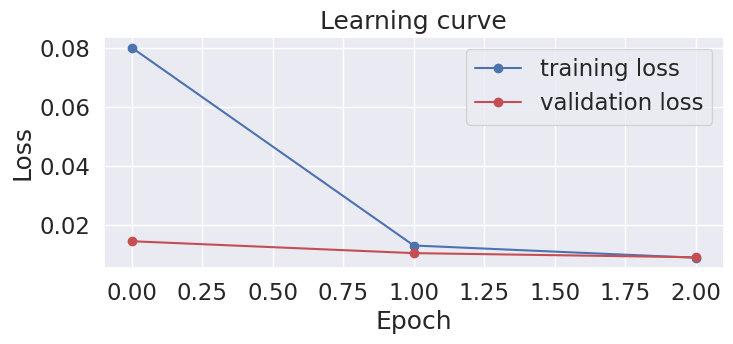

In [7]:
tag2idx = { 'O' : 0, 
            'CRED' : 1, 'B-CRED' : 1, 'I-CRED' : 1, 
            'DEB'  : 2, 'B-DEB'  : 2, 'I-DEB'  : 2,
            'AVBL' : 3, 'B-AVBL' : 3, 'I-AVBL' : 3,
            'PAD'  : 4
          }

max_len = 75 
batch_size = 32 
epochs = 3  

df = pd.read_csv('ner-SMS.csv')
trainer = BertModelTrainer(tag2idx, max_len, batch_size, epochs)
trainer.train(df, df)


In [14]:
import numpy as np
import pandas as pd
import torch

def process_text_data():
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
    # PATH
    model_path = r"tuned_model_.pt"
    # Load the model state dictionary from file
    state_dict = torch.load(model_path)
    # Instantiate a new BERT model object
    tag2idx = { 'O' : 0, 
                'CRED' : 1, 'B-CRED' : 1, 'I-CRED' : 1, 
                'DEB'  : 2, 'B-DEB'  : 2, 'I-DEB'  : 2,
                'AVBL' : 3, 'B-AVBL' : 3, 'I-AVBL' : 3,
                'PAD'  : 4
              }

    model = BertForTokenClassification.from_pretrained(
                                                        "bert-base-cased",
                                                        num_labels=len(tag2idx),
                                                        output_attentions = False,
                                                        output_hidden_states = False
                                                      )
    # Load the saved state dictionary into the new model object
    model.load_state_dict(state_dict)
    index = np.random.randint(0, 108165, size=1)[0]
    test_df_ = pd.read_csv('sms_data.csv')  # UNSEEN DATA
    test_sentence = test_df_['MSG'][index]
    tag_values = list({0: 'O', 1: 'CRED', 2: 'DEB', 3: 'AVBL', 4: 'PAD'})
    idx_to_tokens = {0: "O", 1: 'CRED', 2: 'DEB', 3: 'AVBL', 4: 'PAD'}
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
    
    tokenized_sentence = tokenizer.encode(test_sentence)
    input_ids = torch.tensor([tokenized_sentence])

    with torch.no_grad():
        output = model(input_ids)
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

    tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)

    credited_amount = ''
    debited_amount = ''
    available_amount = ''
    for token, label in zip(new_tokens, new_labels):
        if idx_to_tokens[label] == 'CRED':
            credited_amount += token
        elif idx_to_tokens[label] == 'DEB':
            debited_amount += token
        elif idx_to_tokens[label] == 'AVBL':
            available_amount += token

    print('\n',test_sentence,'\n')
    predicted_df = pd.DataFrame(data=[credited_amount, debited_amount, available_amount],
                                index=['Credited', 'Debited', 'Available'], columns=['AMOUNT'])
    return predicted_df.T

result = process_text_data()
result


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas


 Rs.1,400.00 spent on your SBI Card ending with 9196 at BIG BAZAAR , on 15/08/21. If this trxn. wasnt done by you, click https://sbicard.com/DisputeRaise 



,Credited,Debited,Available
AMOUNT,"Rs1,400.00",,
